In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import scipy 
import scipy.stats as ss
import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest
sys.path.append('../Script/')
import FM_States
import FM_selection
import TF
#from FM_States import *
import rpy2
from rpy2.robjects.packages import importr
from sklearn.neighbors import KNeighborsClassifier
import random

base = importr('base')
CC = importr('ConsensusClusterPlus')
pheatmap = importr('pheatmap')
bezier = importr('bezier')

ROOT_DIR = os.path.abspath("../")

In [2]:
para = {
    'output_dir': ROOT_DIR+"/Sample_output/Example2/",
    'input_fmf_file_drug': ROOT_DIR +  "/Sample_output/Example1/matrix_factor_mcf7.csv",
    'input_fmf_file_sh':ROOT_DIR + "/Sample_output/Example2/matrix_factor_sh_mcf7.csv",
    'annotation_col':ROOT_DIR + "/Sample_output/Example1/annotation_col.csv",
    'selected_factor':ROOT_DIR +"/Sample_output/Example1/Features_diff_all.csv",
    'meta':ROOT_DIR + '/Sample_input/Example2/MetaData_sig_info_sh_MCF7_96h.csv',
    
}

In [3]:
output_dir = para['output_dir']
try:
    os.mkdir(output_dir)
except OSError:
    print ("Info: Creation of the directory failed!\nThe direcory of %s may already exsit!" % output_dir)
else:
    print ("Successfully created the directory %s " % output_dir)
    

Info: Creation of the directory failed!
The direcory of /project/Sample_output/Example2/ may already exsit!


In [4]:
matrix_factor_sh_MCF7 = pd.read_csv(para['input_fmf_file_sh'], index_col = 'Unnamed: 0')
matrix_factor = pd.read_csv(para['input_fmf_file_drug'], index_col = 'Unnamed: 0')
annotation_col_1 = pd.read_csv(para['annotation_col'], index_col= 'Unnamed: 0')
colors = ['red','pink','#fdd5ac','#8895df', 'cyan'] #Define the colors for cluster annotation
output_dir = para['output_dir']
select_modules =pd.read_csv(para['selected_factor'],index_col= 'Unnamed: 0')
meta_sh = pd.read_csv(para['meta'])  ## Annotation data for shRNA
meta_sh.index = meta_sh['sig_id']

In [25]:
select_modules

,Carbohydrate metabolism_up,Membrane transport_up,Signaling molecules and interaction_up,Transport and catabolism_up,Folding sorting and degradation_tf,Lipid metabolism_tf,Signaling molecules and interaction_tf,Transport and catabolism_tf,Cell motility_tf,Translation_down,...,Cellular senescence_down,p53 signaling pathway_down,Folding sorting and degradation_ssGSEA,Nucleotide metabolism_ssGSEA,Replication and repair_ssGSEA,Transcription_ssGSEA,Translation_ssGSEA,Replication and repair_tf,Cell cycle_tf,Cellular senescence_tf
S2,-0.842137,-0.749050,-0.395911,-0.747060,0.150953,0.136009,0.222026,0.237174,0.014765,-0.671728,...,-0.847714,-0.787169,-0.750859,0.056793,0.204667,-0.387573,-0.320110,0.591218,0.608147,0.485264
S5,1.369734,1.217978,1.635456,1.432606,2.069290,1.614555,2.411984,1.577198,1.889545,1.438075,...,1.176272,0.982059,-1.403204,-0.953937,-0.876655,-1.357067,-1.440178,1.115875,1.028333,1.024285
S4,1.603662,1.500208,1.327890,1.572171,0.356778,0.619957,-0.045270,0.757047,0.733088,1.488860,...,1.563108,1.441733,-0.332132,-1.464833,-1.690883,-0.935038,-1.037394,-2.461859,-2.521460,-1.942278
S1,-1.638009,-1.246612,-1.975294,-1.881662,-1.127527,-1.135085,-1.151315,-1.089239,-1.138606,-1.827109,...,-1.664955,-1.438185,1.428101,2.020029,1.884383,2.000000,2.047389,0.154824,0.172999,-0.016001
S3,0.661579,0.405481,0.395969,0.705191,-0.437831,-0.361807,-0.366034,-0.582697,-0.431560,0.630927,...,0.840625,0.805195,0.453976,-0.404043,-0.442347,0.062334,0.072080,-0.429013,-0.392372,-0.219912


In [31]:
from sklearn.neighbors import KNeighborsClassifier
import random
y = annotation_col_1.loc[list(matrix_factor.index.values)]  ## use the states after drug treatment as labels;
x = matrix_factor[list(select_modules)].values              ## use the states after drug treatment as training set;
y_test = matrix_factor_sh_MCF7[list(select_modules)]        ## use the FM-factors after shRNA knockdown as the testing set;

In [32]:
#from sklearn.neighbors import KNeighborsClassifier
#import random
#y = annotation_col_1.loc[list(matrix_factor.index.values)]  ## use the states after drug treatment as labels;
#x = matrix_factor.values              ## use the states after drug treatment as training set;
#y_test = matrix_factor_sh_MCF7       ## use the FM-factors after shRNA knockdown as the testing set;

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

#split dataset into train and test data
x_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=25223, stratify=y)

In [34]:
dic_train = {}
dic_test = {}
score_dic_train = {}
score_dic_test = {}

score_cv = {}
score_cv_rf = {}
num_neighbors = -1
while num_neighbors < 30:
    num_neighbors = num_neighbors + 2
    score_list_train = []
    score_list_test = []
    
    
    neigh = KNeighborsClassifier(n_neighbors = num_neighbors)
    #neigh.fit(x_train, y_train) 
    rf_clf = RandomForestClassifier(max_depth = num_neighbors)
    
    cv_scores = cross_val_score(neigh, x, y['States'].values, cv=5, scoring = 'accuracy')
    cv_scores_rf = cross_val_score(rf_clf, x, y['States'].values, cv=5, scoring = 'accuracy')

    #print each cv score (accuracy) and average them
    print(cv_scores)
    ave_score = (np.mean(cv_scores))
    score_cv[num_neighbors] = [ave_score, np.std(cv_scores)]
    
    
    print(cv_scores_rf)
    ave_score_rf = (np.mean(cv_scores_rf))
    score_cv_rf[num_neighbors] = [ave_score_rf, np.std(cv_scores_rf)]
    
    #score_list_train.append(neigh.score(x_train,y_train))
    #score_list_test.append(neigh.score(X_val, y_val))
    
    #score_dic_train[num_neighbors] = score_list_train
    #score_dic_test[num_neighbors] = score_list_test
#score_df_train = pd.DataFrame.from_dict(score_dic_train)
#score_df_test = pd.DataFrame.from_dict(score_dic_test)
score_cv

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

[0.76744186 0.74031008 0.73255814 0.63424125 0.6796875 ]
[0.48449612 0.47674419 0.48449612 0.49805447 0.46875   ]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

[0.74418605 0.77906977 0.75193798 0.64202335 0.6796875 ]
[0.78682171 0.85271318 0.87596899 0.80933852 0.8046875 ]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

[0.77131783 0.77131783 0.75193798 0.6381323  0.69921875]
[0.8372093  0.89922481 0.85658915 0.83268482 0.8515625 ]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

[0.7751938  0.79457364 0.75581395 0.63424125 0.66796875]
[0.84496124 0.88372093 0.89922481 0.85214008 0.83984375]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

[0.76744186 0.78682171 0.76356589 0.62256809 0.68359375]
[0.86046512 0.8875969  0.89534884 0.83268482 0.859375  ]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

[0.75968992 0.78682171 0.76744186 0.64980545 0.67578125]
[0.84496124 0.89534884 0.87984496 0.84435798 0.87890625]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

[0.75581395 0.79069767 0.75968992 0.6381323  0.67578125]
[0.84108527 0.87209302 0.8875969  0.87159533 0.89453125]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

[0.75581395 0.79069767 0.74806202 0.62645914 0.68359375]
[0.85658915 0.89534884 0.87209302 0.85992218 0.85546875]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

[0.75193798 0.79069767 0.74418605 0.61478599 0.67578125]
[0.85271318 0.92635659 0.89922481 0.78599222 0.8359375 ]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

[0.75581395 0.79069767 0.72093023 0.61478599 0.67578125]
[0.8372093  0.87209302 0.87209302 0.82490272 0.8515625 ]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

[0.75581395 0.80232558 0.72093023 0.61089494 0.67578125]
[0.87209302 0.89534884 0.87984496 0.83657588 0.8515625 ]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

[0.76744186 0.78682171 0.72093023 0.61867704 0.671875  ]
[0.86434109 0.90310078 0.8875969  0.84046693 0.8515625 ]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

[0.75968992 0.79457364 0.72093023 0.62256809 0.66796875]
[0.85271318 0.87984496 0.87984496 0.82879377 0.84375   ]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

[0.76356589 0.78682171 0.72093023 0.61867704 0.66796875]
[0.8255814  0.89147287 0.8875969  0.79766537 0.8203125 ]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

[0.76356589 0.78294574 0.71705426 0.61867704 0.671875  ]
[0.86046512 0.87984496 0.89534884 0.84046693 0.84375   ]
[0.77131783 0.77906977 0.72093023 0.60700389 0.671875  ]
[0.87596899 0.8875969  0.8875969  0.84435798 0.859375  ]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

{1: [0.7108477645311133, 0.04771117450548513],
 3: [0.7193809289506229, 0.05059204889763897],
 5: [0.7263849378261394, 0.051414819448388854],
 7: [0.7255582780970048, 0.06292466238076869],
 9: [0.724798260149911, 0.0621564675695584],
 11: [0.727908037168582, 0.05451797535498234],
 13: [0.7240230192214883, 0.0573285021896912],
 15: [0.7209253074759449, 0.05854793414507411],
 17: [0.7154777895288511, 0.06249191022067417],
 19: [0.711601820536603, 0.06156996663782748],
 21: [0.7131491918152204, 0.06585673799664936],
 23: [0.7131491682502338, 0.06174856042890418],
 25: [0.7131461283669653, 0.06181057060413398],
 27: [0.7115927244517841, 0.06161846114567729],
 29: [0.7108235868548849, 0.060050236448469775],
 31: [0.7100393441015896, 0.06436099022162188]}

In [35]:
score_cv_rf

{1: [0.48250818176333965, 0.009717018733154585],
 3: [0.825905979473954, 0.0330974807882699],
 5: [0.8554541161433356, 0.0235950000420444],
 7: [0.8639781609130395, 0.02330817974501825],
 9: [0.8670941355231804, 0.02238848406442711],
 11: [0.8686838530826773, 0.020467533966316474],
 13: [0.87338035490755, 0.01842436676613972],
 15: [0.8678843873480531, 0.014947480611448077],
 17: [0.8600448583084488, 0.0490938402894342],
 19: [0.8515721145145235, 0.018760395849126407],
 21: [0.8670850394383617, 0.02077737272327107],
 23: [0.8694136371519925, 0.023011997965060732],
 25: [0.856989375018852, 0.020165884315790878],
 27: [0.8445258064881006, 0.037947914566395],
 29: [0.8639751681597442, 0.021024617853812842],
 31: [0.8709791534702742, 0.01685550872453288]}

In [36]:
score_cv

{1: [0.7108477645311133, 0.04771117450548513],
 3: [0.7193809289506229, 0.05059204889763897],
 5: [0.7263849378261394, 0.051414819448388854],
 7: [0.7255582780970048, 0.06292466238076869],
 9: [0.724798260149911, 0.0621564675695584],
 11: [0.727908037168582, 0.05451797535498234],
 13: [0.7240230192214883, 0.0573285021896912],
 15: [0.7209253074759449, 0.05854793414507411],
 17: [0.7154777895288511, 0.06249191022067417],
 19: [0.711601820536603, 0.06156996663782748],
 21: [0.7131491918152204, 0.06585673799664936],
 23: [0.7131491682502338, 0.06174856042890418],
 25: [0.7131461283669653, 0.06181057060413398],
 27: [0.7115927244517841, 0.06161846114567729],
 29: [0.7108235868548849, 0.060050236448469775],
 31: [0.7100393441015896, 0.06436099022162188]}

In [39]:
k_list = []
mean_list = []
sd_list = []
uper_list = []
lower_list = []
for k in score_cv:
    k_list.append(k)
    mean_list.append(score_cv[k][0])
    uper_list.append(score_cv[k][0] + score_cv[k][1] )
    lower_list.append(score_cv[k][0] - score_cv[k][1] )
    #sd_list.append(score_cv[k][1])

In [40]:
sd_list

[]

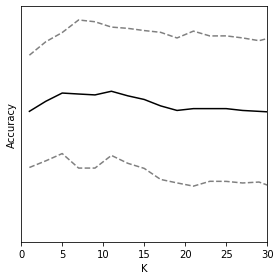

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 4))

#plt.plot(range(0,100), score_df_train, 'grey')

plt.plot(k_list, mean_list, 'black','o')
plt.plot(k_list, lower_list, 'grey', linestyle='dashed')
plt.plot(k_list, uper_list, 'grey', linestyle='dashed')
plt.axis([0, 30, 0.6, 0.8])

plt.xlabel("K")
plt.ylabel("Accuracy")
#plt.plot(range(0,12), score_list_test, 'red')
plt.tight_layout()
plt.savefig(output_dir+'/AUC_for_K.png', dpi=300)
plt.show()

In [17]:
score_cv

{1: [0.7108477645311133, 0.04771117450548513],
 3: [0.7193809289506229, 0.05059204889763897],
 5: [0.7263849378261394, 0.051414819448388854],
 7: [0.7255582780970048, 0.06292466238076869],
 9: [0.724798260149911, 0.0621564675695584],
 11: [0.727908037168582, 0.05451797535498234],
 13: [0.7240230192214883, 0.0573285021896912],
 15: [0.7209253074759449, 0.05854793414507411],
 17: [0.7154777895288511, 0.06249191022067417],
 19: [0.711601820536603, 0.06156996663782748],
 21: [0.7131491918152204, 0.06585673799664936],
 23: [0.7131491682502338, 0.06174856042890418],
 25: [0.7131461283669653, 0.06181057060413398],
 27: [0.7115927244517841, 0.06161846114567729],
 29: [0.7108235868548849, 0.060050236448469775],
 31: [0.7100393441015896, 0.06436099022162188]}